In [1]:
import tensorflow as tf
from tensorflow.python.layers.base import Layer
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import time

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("mnist/", one_hot=True)
num_train=mnist.train.num_examples
num_val=mnist.validation.num_examples
num_test=mnist.test.num_examples

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


In [12]:
# def normalize(images):
#     min_v=np.min(images)
#     max_v=np.max(images)
#     images-=min_v
#     images/=((max_v-min_v)/2)
#     images-=1.0
#     return images

def normalize01(images):
    min_v=np.min(images)
    max_v=np.max(images)
    images-=min_v
    images/=(max_v-min_v)
    return images

def normalize(images):
    return images

In [4]:
batch_size=64
hidden_size=1024
image_size=784

class Encoder_dense(Layer):
    def __init__(self):
        self.hidden_size_low=1024
        self.hidden_size=1024
        self.encoder_low1=tf.layers.Dense(units=self.hidden_size_low,activation=tf.nn.relu,name='encoder_low1')
        self.encoder_low2=tf.layers.Dense(units=self.hidden_size_low,activation=tf.nn.relu,name='encoder_low2')
        self.encoder_output1=tf.layers.Dense(units=self.hidden_size,name='encoder_mean')
        self.encoder_output2=tf.layers.Dense(units=self.hidden_size,name='encoder_std')
    
    def __call__(self,inputs):
        encode_hid=self.encoder_low2(self.encoder_low1(inputs))
        encode_mean=self.encoder_output1(encode_hid)
        encode_std=self.encoder_output2(encode_hid)
        return encode_mean,encode_std
    
class Decoder_dense(Layer):
    def __init__(self):
        self.hidden_size_low=1024
        self.decoder_low1=tf.layers.Dense(units=self.hidden_size_low,activation=tf.nn.relu,name='decoder_low1')
        self.decoder_low2=tf.layers.Dense(units=self.hidden_size_low,activation=tf.nn.relu,name='decoder_low2')
        self.decoder_top=tf.layers.Dense(units=image_size,name='decoder')
    
    def __call__(self,inputs):
        return self.decoder_top(self.decoder_low2(self.decoder_low1(inputs)))
    
class Encoder_conv(Layer):
    def __init__(self):
        self.hidden_size=1024
        self.encoder_low1=tf.layers.Conv2D(filters=64,kernel_size=5,strides=(2,2),activation=tf.nn.relu,name='encoder_low1')
        self.encoder_low2=tf.layers.Conv2D(filters=64,kernel_size=3,activation=tf.nn.relu,name='encoder_low2')
        self.encoder_low3=tf.layers.Conv2D(filters=64,kernel_size=3,activation=tf.nn.relu,name='encoder_low3')
        self.encoder_output1=tf.layers.Dense(units=self.hidden_size,name='encoder_mean')
        self.encoder_output2=tf.layers.Dense(units=self.hidden_size,name='encoder_std')
    
    def __call__(self,inputs):
        encode_hid=self.encoder_low3(self.encoder_low2(self.encoder_low1(inputs)))
        encode_hid=tf.layers.flatten(encode_hid)
        encode_mean=self.encoder_output1(encode_hid)
        encode_std=self.encoder_output2(encode_hid)
        return encode_mean,encode_std
    
class Decoder_conv(Layer):
    def __init__(self):
        self.decoder_top=tf.layers.Dense(units=4096,name='decoder')
        self.decoder_low3=tf.layers.Conv2DTranspose(64,3,activation=tf.nn.relu,name='decoder_low3')
        self.decoder_low2=tf.layers.Conv2DTranspose(64,3,activation=tf.nn.relu,name='decoder_low2')
        self.decoder_low1=tf.layers.Conv2DTranspose(1,6,strides=(2,2),activation=tf.nn.relu,name='decoder_low1')
    
    def __call__(self,inputs):
        decode_hid=self.decoder_top(inputs)
        decode_hid=tf.reshape(decode_hid,shape=[-1,8,8,64])
        decode_hid=self.decoder_low3(decode_hid)
        decode_hid=self.decoder_low2(decode_hid)
        decode_hid=self.decoder_low1(decode_hid)
        return tf.layers.flatten(decode_hid)
        

tf.reset_default_graph()
X=tf.placeholder(shape=[None,image_size],dtype=tf.float32,name='input')
X_conv=tf.reshape(X,shape=[-1,28,28,1])

encoder=Encoder_conv()
decoder=Decoder_conv()

encode_mean,encode_std=encoder(X_conv)
distrib_encode=tf.distributions.Normal(loc=encode_mean,scale=encode_std,name='norm1')
unit_gaussian=tf.distributions.Normal(loc=tf.zeros(encoder.hidden_size),scale=tf.ones(encoder.hidden_size),name='unit_norm')

# Z=encoder(encoder_low2(encoder_low1(X)))  # Vanillia auto_encoder(trivial)
Z=distrib_encode.sample()

X_gen=decoder(Z)

loss1=tf.reduce_mean(tf.square(X_gen-X)) # gaussian distribution
# X_gen=tf.nn.sigmoid(X_gen)
# loss1=-(tf.reduce_mean(X*tf.log(1e-10+X_gen)+(1.0-X)*tf.log(1e-10+1.0-X_gen)))  # Bernoulli distribution
loss2=tf.reduce_mean(tf.distributions.kl_divergence(distrib_encode,unit_gaussian))
# loss2=tf.constant(dtype=tf.float32,value=0)
loss=loss1+loss2

global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 1e-3
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,num_train//64, 0.98, staircase=True)
optimizier=tf.train.AdamOptimizer(learning_rate=starter_learning_rate)
train_step = optimizier.minimize(loss,global_step=global_step)
# train_step = optimizier.minimize(loss)

In [5]:
def drawImage(sample):
    plt.figure(figsize = (3,3))
    gs1 = gridspec.GridSpec(3, 3)
    gs1.update(wspace=0.025, hspace=0.05)

    for i in range(9):
        plt.subplot(gs1[i])
        feature_submap=sample[i,:].reshape(28,28)
        plt.imshow(feature_submap)
        plt.axis('off')
    plt.show()

In [ ]:
max_epoch=300
print_every=100
num_iteration=num_train//batch_size
loss_his=[]
loss1_his=[]
loss2_his=[]

saver=tf.train.Saver()
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for epoch in range(max_epoch):
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),
                  'start epoch %d/%d, with learning rate = %.10f' % (epoch+1,max_epoch,sess.run(learning_rate)))
        average_loss=0
        average_loss1=0
        average_loss2=0
        for it in range(num_iteration):
            images,labels=mnist.train.next_batch(batch_size)
            loss_num,l1,l2,_=sess.run([loss,loss1,loss2,train_step],feed_dict={X:normalize(images)})
            average_loss+=loss_num
            average_loss1+=l1
            average_loss2+=l2
            if it==0 or (it+1)%print_every==0 or it==num_iteration-1:
                print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),
                      'iteration %d/%d:' % (it+1,num_iteration),'current training loss = %f (=%f+%f)' % (loss_num,l1,l2))
        average_loss/=num_iteration
        average_loss1/=num_iteration
        average_loss2/=num_iteration
        images,labels=mnist.train.next_batch(9)
        drawImage(images)
        d_output=sess.run(X_gen,feed_dict={X:normalize(images)})
        drawImage(d_output)
#         g_output=sess.run(generate_output,feed_dict={sample_size:9})
#         drawImage(g_output)
        loss_his.append(average_loss)
        loss1_his.append(average_loss1)
        loss2_his.append(average_loss2)
        save_path = saver.save(sess, "parameters/VAE/VAE.ckpt")
        print("model saved in path: %s" % save_path)
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),'end epoch %d/%d:' % (epoch+1,max_epoch),
             'average loss =',average_loss,'(=%f+%f)' % (average_loss1,average_loss2))
        print()

In [ ]:
plt.figure(1)
ptr,=plt.plot(range(max_epoch),loss_his,'r-')
pva,=plt.plot(range(max_epoch),loss1_his,'b-')
pte,=plt.plot(range(max_epoch),loss2_his,'y-')
plt.xlabel('training epoch')
plt.ylabel('loss')
plt.title('Three kinds of loss')
plt.legend((ptr,pva,pte),('total loss','RC loss','KL loss'))
plt.show()

INFO:tensorflow:Restoring parameters from parameters/VAE.ckpt


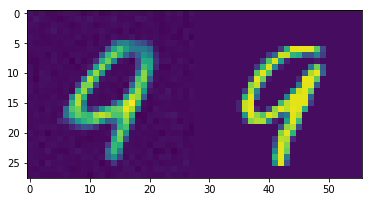

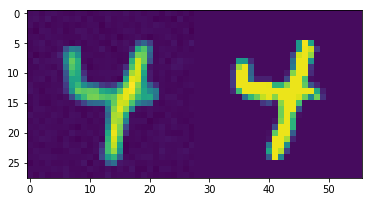

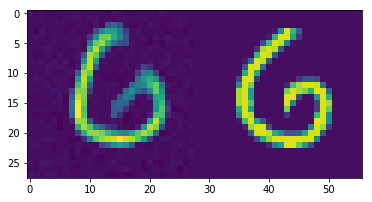

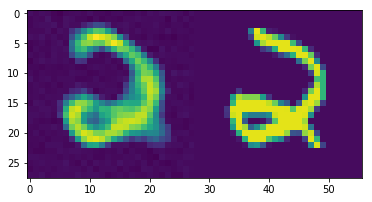

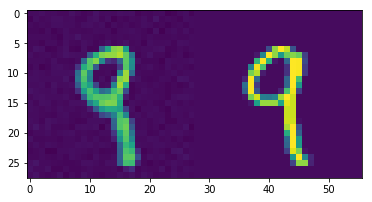

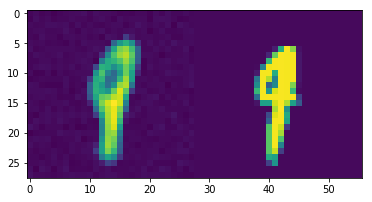

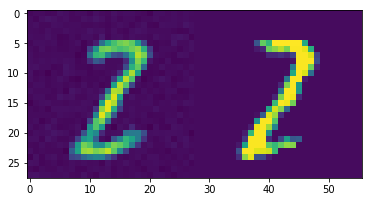

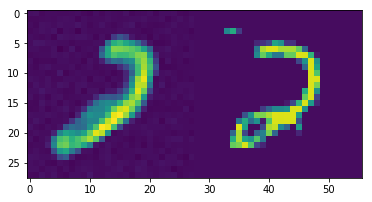

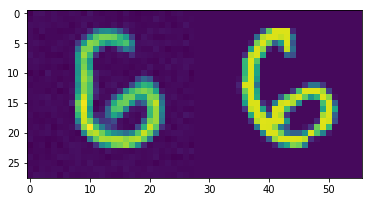

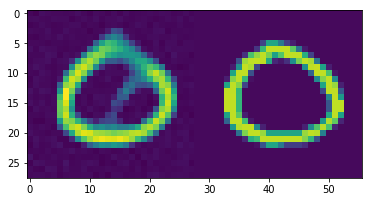

In [17]:
std=0.01
Z_gt=tf.expand_dims(unit_gaussian.sample(),axis=0)
X_generate_mean=decoder(Z_gt)
generate_distrib=tf.distributions.Normal(loc=X_generate_mean,scale=tf.ones(784)*std)
generate_result=generate_distrib.sample()

def nearest_neighbour(X_train,image):
    dis=np.sum(np.square(X_train-image),axis=1)
    index=np.argmin(dis)
    return X_train[index,:]

saver=tf.train.Saver()
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    saver.restore(sess, "parameters/VAE/VAE.ckpt")
    for i in range(10):
        img_np=sess.run(generate_result)
        nn=nearest_neighbour(mnist.train.images,img_np)
#         img_np=normalize01(img_np)
#         img_np[np.where(img_np>0.3)]=1
        img=np.hstack((img_np.reshape(28,28),nn.reshape(28,28)))
        plt.imshow(img)
        plt.show()

In [ ]:
mean_graph=np.zeros(784)
num_iteration=num_train//batch_size
for it in range(num_iteration):
    images,labels=mnist.train.next_batch(batch_size)
    mean_graph+=np.sum(images,axis=0)
mean_graph/=(num_iteration)
plt.imshow(mean_graph.reshape(28,28))
plt.show()